# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), 

**Required Libraries -** The following R libraries are referenced in this notebook
* glmnet
* ROCR
---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

[3. XGBoost](#3.-XGBoost)

[4. Random Forest](#4.-Random-Forest)

---

In [599]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)
seed=123

In [646]:
# install packages ggplot2 for more fancier plots and graphs
# and psych for a more comprehensive stats package
# only install if not already installed
list.of.packages <- c("ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret", "xgboost", "Matrix", "Ckmeans.1d.dp", 
                     "randomForest", "caretEnsemble", "MASS")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org")

also installing the dependencies 'pbapply', 'gridExtra'



package 'pbapply' successfully unpacked and MD5 sums checked
package 'gridExtra' successfully unpacked and MD5 sums checked
package 'caretEnsemble' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jmills\AppData\Local\Temp\RtmpkLSoid\downloaded_packages


In [650]:
# import ggplot for some of the more fancier plots if needed
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")
library("caretEnsemble")
library("MASS")

library("xgboost")
library("Matrix")
library("Ckmeans.1d.dp")
library("randomForest")

In [602]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [603]:
prostate <- read.csv("./prostate.csv")

In [604]:
# Before we do anything, dedicate 20% of our data to an unseen Test set.

# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

In [605]:
# Check the head of the dataframe
head(train)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
2067,2067,2,2,4,2,4,2,4,5,6,4,1
1431,1431,10,3,3,4,3,3,8,6,5,7,2
2228,2228,2,8,6,8,2,1,3,10,1,2,1
134,134,9,9,2,8,9,10,3,4,9,3,2
2775,2775,6,4,4,8,9,6,1,1,4,5,1
429,429,2,3,2,7,4,3,10,9,3,8,2


In [606]:
# Check structure of the datatypes
str(train)

'data.frame':	2400 obs. of  12 variables:
 $ ID    : int  2067 1431 2228 134 2775 429 1834 395 787 2242 ...
 $ ATT1  : int  2 10 2 9 6 2 6 2 10 8 ...
 $ ATT2  : int  2 3 8 9 4 3 3 4 7 1 ...
 $ ATT3  : int  4 3 6 2 4 2 2 5 2 6 ...
 $ ATT4  : int  2 4 8 8 8 7 7 6 2 2 ...
 $ ATT5  : int  4 3 2 9 9 4 4 3 7 6 ...
 $ ATT6  : int  2 3 1 10 6 3 3 3 5 8 ...
 $ ATT7  : int  4 8 3 3 1 10 6 3 3 8 ...
 $ ATT8  : int  5 6 10 4 1 9 2 6 4 3 ...
 $ ATT9  : int  6 5 1 9 4 3 4 6 5 9 ...
 $ ATT10 : int  4 7 2 3 5 8 3 6 2 1 ...
 $ Result: int  1 2 1 2 1 2 0 1 0 0 ...


We can drop the ID column as it adds no benefit to our modelling

In [607]:
train$ID <- NULL

Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [608]:
train$Result <- as.factor(train$Result) 

In [609]:
# Let's check for incomplete observations
nrow(train[complete.cases(train),])

[1] 2400

In [610]:
# Check the proportions of each factor within the Result variable in our train set
print(table(train$Result))


  0   1   2   3 
880 841 520 159 


In [611]:
# Check the proportions of each factor within the Result variable in our test set
print(table(test$Result))


  0   1   2   3 
202 239 122  37 


We have class imbalance. This will need to be addressed when training our models, potentially with some sampling techniques. 

In [612]:
round(describe(train), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ATT1,1.000,2400.000,5.789,2.676,6.000,5.736,2.965,2.000,10.000,8.000,0.113,-1.188,0.055
ATT2,2.000,2400.000,4.507,2.744,4.000,4.321,2.965,1.000,10.000,9.000,0.411,-0.965,0.056
ATT3,3.000,2400.000,5.814,2.643,6.000,5.768,2.965,2.000,10.000,8.000,0.108,-1.159,0.054
ATT4,4.000,2400.000,5.808,2.649,6.000,5.760,2.965,2.000,10.000,8.000,0.097,-1.169,0.054
ATT5,5.000,2400.000,5.768,2.610,6.000,5.710,2.965,2.000,10.000,8.000,0.125,-1.114,0.053
ATT6,6.000,2400.000,4.407,2.678,4.000,4.214,2.965,1.000,10.000,9.000,0.455,-0.915,0.055
ATT7,7.000,2400.000,4.464,2.747,4.000,4.277,2.965,1.000,10.000,9.000,0.409,-1.025,0.056
ATT8,8.000,2400.000,4.508,2.745,4.000,4.327,2.965,1.000,10.000,9.000,0.381,-0.996,0.056
ATT9,9.000,2400.000,4.409,2.675,4.000,4.207,2.965,1.000,10.000,9.000,0.460,-0.865,0.055
ATT10,10.000,2400.000,4.462,2.707,4.000,4.272,2.965,1.000,10.000,9.000,0.420,-0.931,0.055


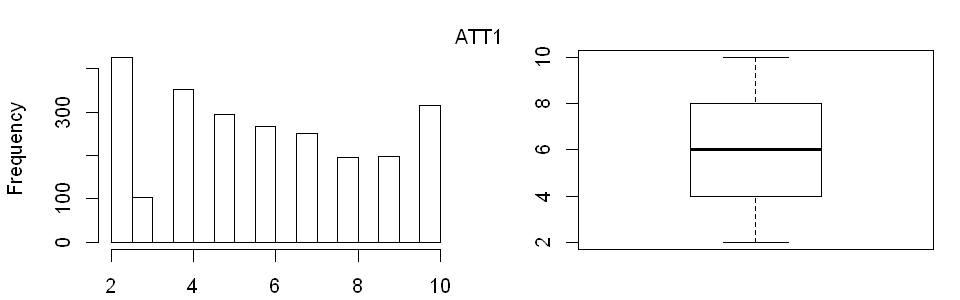

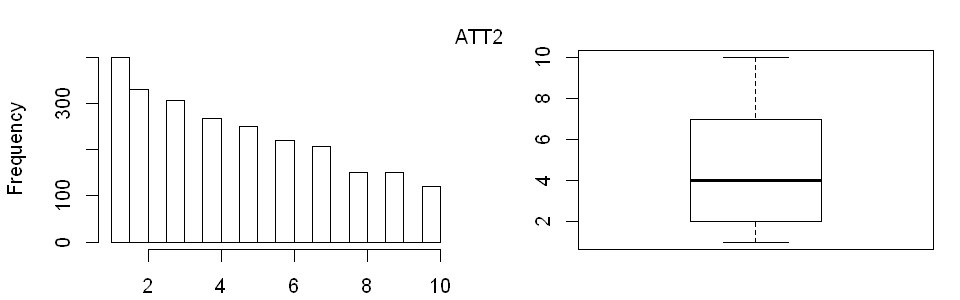

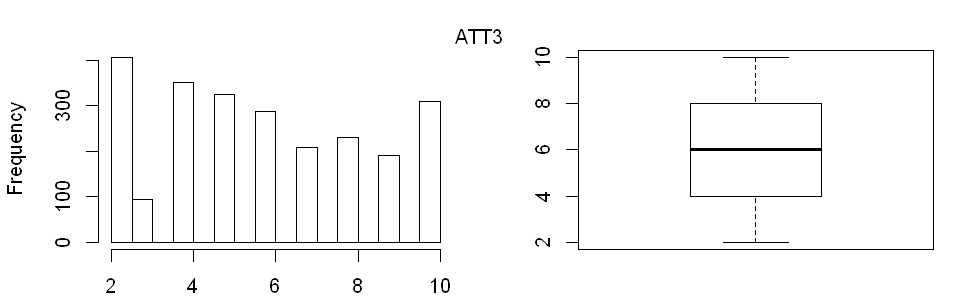

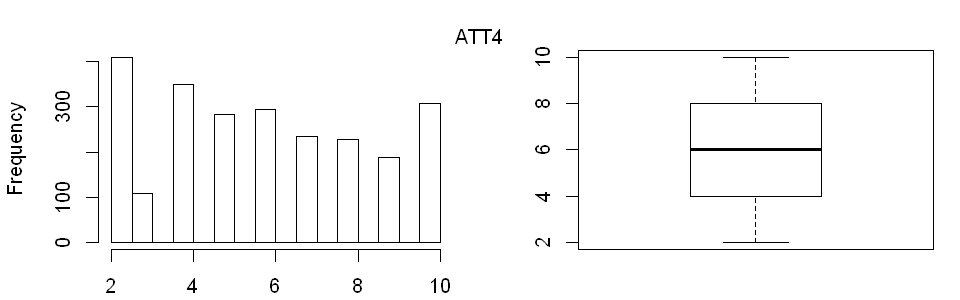

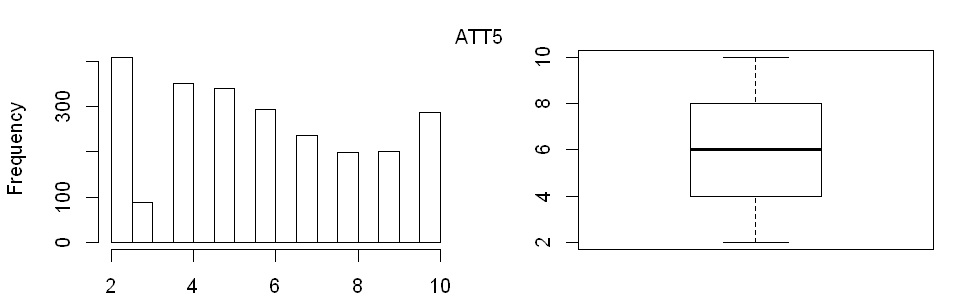

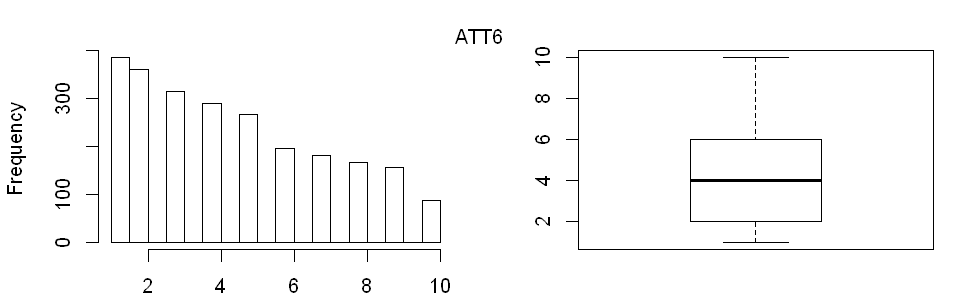

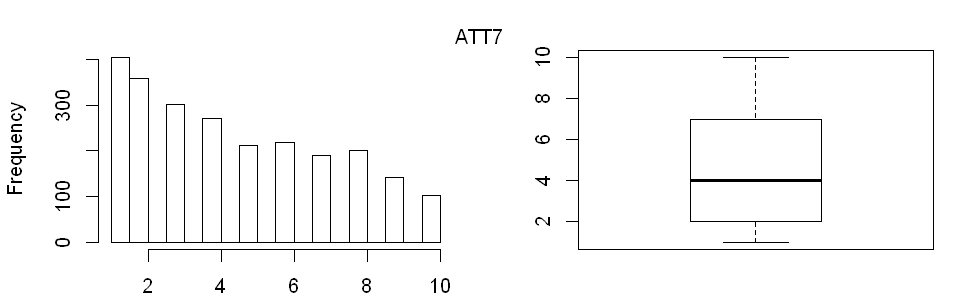

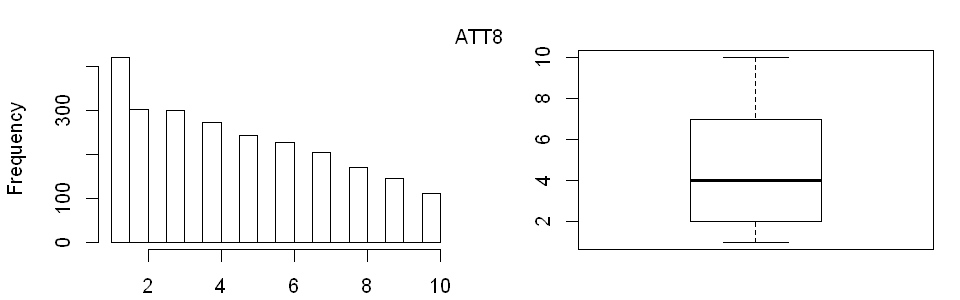

ERROR: Error in hist.default(train[[i]], xlab = NULL, main = NULL): 'x' must be numeric


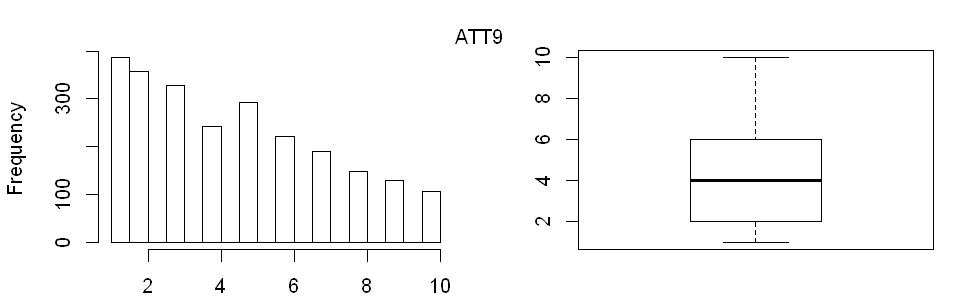

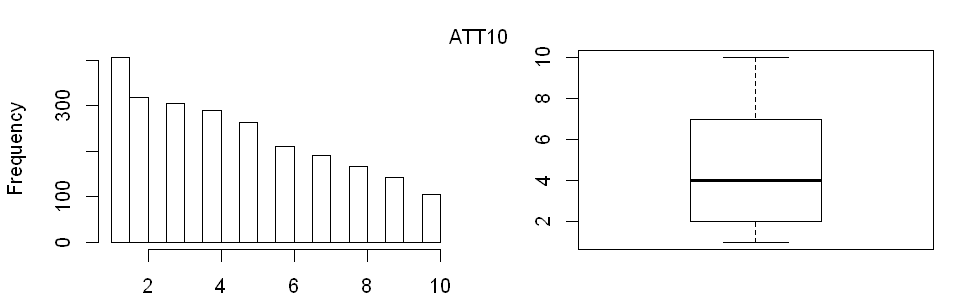

In [613]:
oldpar <- par() #this records all the default settings
par(mfrow=c(1,2)) # this makes to plots in one row
par(mar=c(2.1,4.1,2.1,1.1)) #BLTR
options(repr.plot.width=8, repr.plot.height=2.5)
for (i in names(train)) {
    if (i != "quality") {
        hist(train[[i]],xlab=NULL,main=NULL)
        boxplot(train[[i]])
        mtext(i,side=3,line=-2, outer=TRUE)
    }
}
suppressWarnings( par(oldpar)) # Restore settings

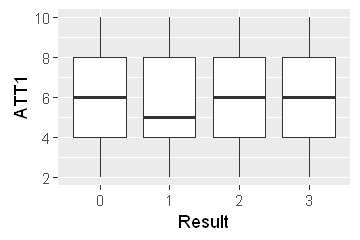

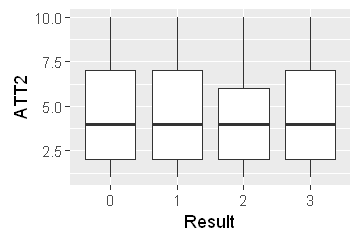

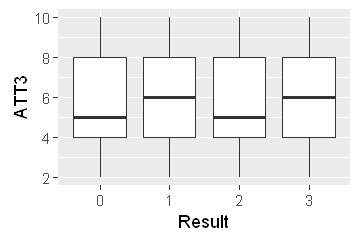

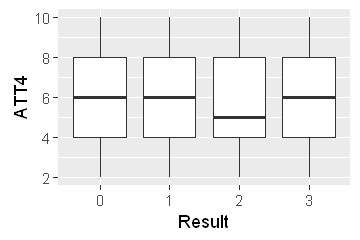

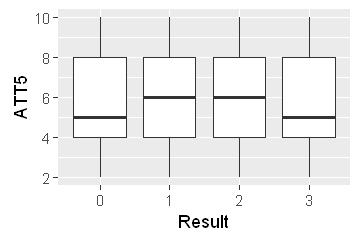

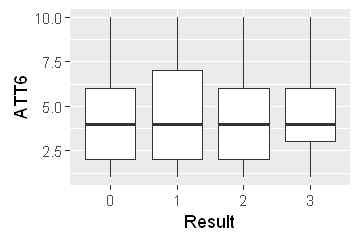

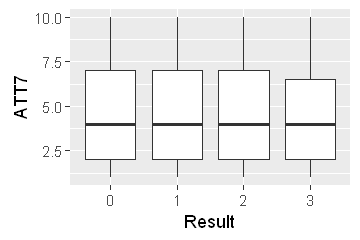

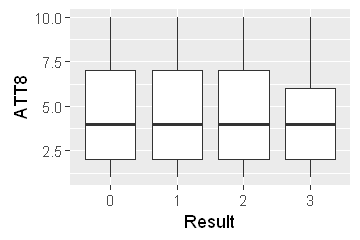

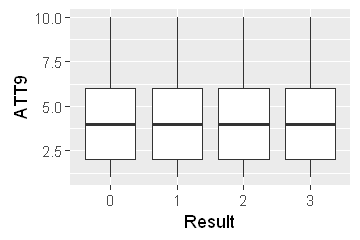

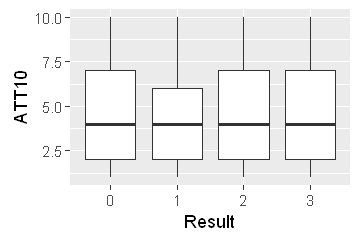

In [614]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
ggplot(train, aes(x = Result, y = ATT1)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT2)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT3)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT4)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT5)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT6)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT7)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT8)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT9)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

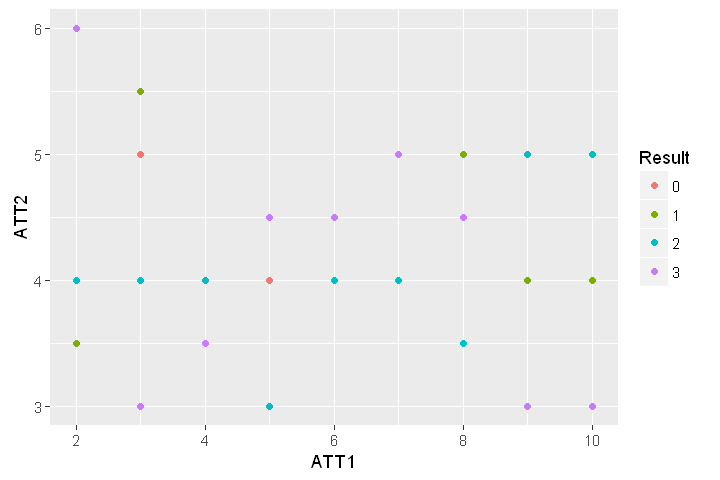

In [615]:
ggplot(aes(x=ATT1, y=ATT2, color=Result),  #by setting color=color, ggplot automatically draw in different colors
       data=train) + geom_point(stat='summary', fun.y=median)

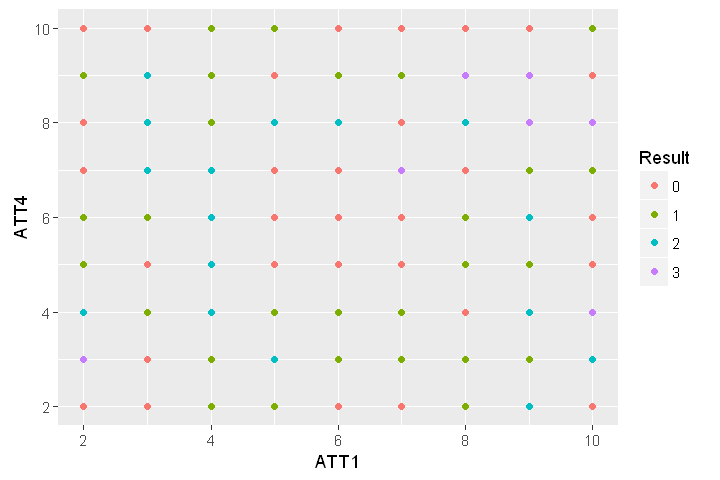

In [616]:
qplot(ATT1, ATT4, colour=Result, data=train)

# 2. EDA Report

Perform an EDA, and prepare a summary of your findings. The summary should be less than 300 words. You need to emphasise on the aspects of the EDA that guide you in choosing a particular model or algorithm for your classifier. If you want to include any chart in your notebook, there should be something you have learnt and you are going to use it in your model selection. Please provide a short explanation on what you have learnt just after the cell. In addition, types of variables, the dimension of the data, and any correlation between variables are very important. Also, you might need to look at some distribution of your variables to get some insights.

# 3. XGBoost

In [617]:
# perform down sampling to obtain even amount of classes
xg_train <- Udf.Utilities.UpSample(train)
xg_test <- test

In [618]:
# Check the proportions of each factor within the Result variable
w <- table(xg_train$Result)
w


  0   1   2   3 
880 880 880 880 

In [619]:
# store the actuals for future comparison
actual <- test$Result

In [620]:
# set the Result to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [621]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [622]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [623]:
# cross validate to select optimal value for number of rounds
n_rounds.cv <- 500
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = 6, eta = 0.1,
               colsample_bytree = 0.9, subsample = 0.9)

bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.499590+0.017950	test-merror:0.614489+0.024108
[20]	train-merror:0.175821+0.009318	test-merror:0.465057+0.024071
[40]	train-merror:0.102778+0.005066	test-merror:0.418182+0.026811
[60]	train-merror:0.062879+0.002783	test-merror:0.397443+0.028768
[80]	train-merror:0.035795+0.002213	test-merror:0.384943+0.025943
[100]	train-merror:0.019949+0.002166	test-merror:0.376705+0.024701
[120]	train-merror:0.011932+0.001753	test-merror:0.368182+0.024336
[140]	train-merror:0.006787+0.001374	test-merror:0.363068+0.024650
[160]	train-merror:0.004009+0.000881	test-merror:0.356534+0.021016
[180]	train-merror:0.002304+0.000517	test-merror:0.352557+0.026259
[200]	train-merror:0.001105+0.000453	test-merror:0.350284+0.025552
[220]	train-merror:0.000694+0.000388	test-merror:0.353125+0.026517
[240]	train-merror:0.000284+0.000276	test-merror:0.351136+0.026891
[260]	train-merror:0.000032+0.000100	test-merror:0.351421+0.025658
[280]	train-merror:0.000000+0.000000	test-merror:0.351705+0.025047
[

In [624]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 394

In [625]:
# create the model
bst <- xgb.train(   params              = param, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xgbTrain-merror:0.357143
[1]	xgbTrain-merror:0.276398
[2]	xgbTrain-merror:0.231366
[3]	xgbTrain-merror:0.208075
[4]	xgbTrain-merror:0.187888
[5]	xgbTrain-merror:0.183230
[6]	xgbTrain-merror:0.172360
[7]	xgbTrain-merror:0.161491
[8]	xgbTrain-merror:0.159938
[9]	xgbTrain-merror:0.163043
[10]	xgbTrain-merror:0.156832
[11]	xgbTrain-merror:0.152174
[12]	xgbTrain-merror:0.155280
[13]	xgbTrain-merror:0.155280
[14]	xgbTrain-merror:0.149068
[15]	xgbTrain-merror:0.145963
[16]	xgbTrain-merror:0.139752
[17]	xgbTrain-merror:0.144410
[18]	xgbTrain-merror:0.142857
[19]	xgbTrain-merror:0.142857
[20]	xgbTrain-merror:0.139752
[21]	xgbTrain-merror:0.141304
[22]	xgbTrain-merror:0.138199
[23]	xgbTrain-merror:0.139752
[24]	xgbTrain-merror:0.138199
[25]	xgbTrain-merror:0.136646
[26]	xgbTrain-merror:0.135093
[27]	xgbTrain-merror:0.131988
[28]	xgbTrain-merror:0.135093
[29]	xgbTrain-merror:0.133540
[30]	xgbTrain-merror:0.138199
[31]	xgbTrain-merror:0.136646
[32]	xgbTrain-merror:0.139752
[33]	xgbTrain-merror

In [626]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [627]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0  73  78  42  13
         1 107 134  65  22
         2  21  24  14   2
         3   1   3   1   0

Overall Statistics
                                        
               Accuracy : 0.368         
                 95% CI : (0.33, 0.408) 
    No Information Rate : 0.398         
    P-Value [Acc > NIR] : 0.939         
                                        
                  Kappa : 0.021         
 Mcnemar's Test P-Value : 0.000000000369

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.361    0.561   0.1148  0.00000
Specificity             0.666    0.463   0.9017  0.99112
Pos Pred Value          0.354    0.409   0.2295  0.00000
Neg Pred Value          0.673    0.614   0.7996  0.93782
Prevalence              0.337    0.398   0.2033  0.06167
Detection Rate          0.122    0.223   0.0233  0.00000
Detection Prevalence    0.343    0.547   0

In [628]:
feature.importance <- xgb.importance(dimnames(xg_train)[[2]], model = bst)
head(feature.importance)

,Feature,Gain,Cover,Frequence
1,ATT10,0.107857670033841,0.101567393814725,0.105844323487016
2,ATT4,0.10614922454135,0.099796011631628,0.101842688410318
3,ATT2,0.105385387374363,0.0976379855805246,0.106261160474172
4,ATT8,0.104060434684283,0.0977903585541646,0.103187323852757
5,ATT7,0.103871379863888,0.100077548390991,0.104082851057421
6,ATT3,0.0997303725460016,0.0911631200520812,0.0995783223252512


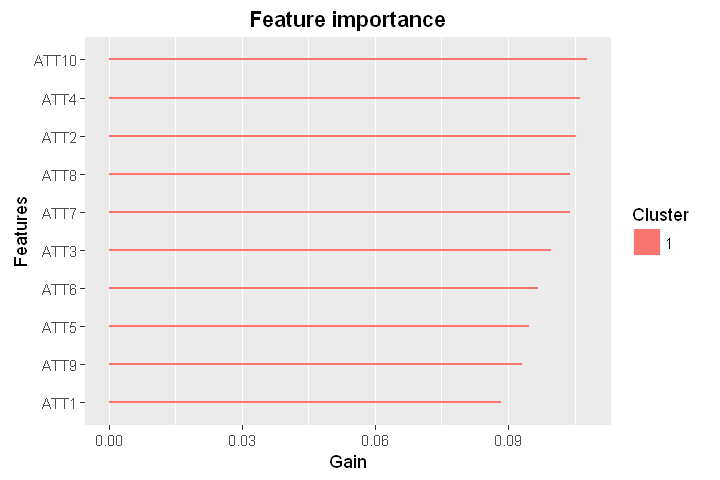

In [629]:
xgb.plot.importance(feature.importance)

## Cross Validate further parameters for XGBoost

# 4. Random Forest

In [630]:
rforest_train <- Udf.Utilities.UpSample(train)
rforest <- randomForest(Result ~., data = rforest_train)

In [631]:
rforest


Call:
 randomForest(formula = Result ~ ., data = rforest_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 34.46%
Confusion matrix:
    0   1   2   3 class.error
0 394 363 106  17    0.552273
1 380 395  99   6    0.551136
2 126 109 639   6    0.273864
3   1   0   0 879    0.001136

In [632]:
pred <- predict(rforest, test)

In [633]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0  90 117  57  23
         1  85  93  54  11
         2  26  27  11   3
         3   1   2   0   0

Overall Statistics
                                        
               Accuracy : 0.323         
                 95% CI : (0.286, 0.362)
    No Information Rate : 0.398         
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : -0.034        
 Mcnemar's Test P-Value : 0.000000000454

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.446    0.389   0.0902   0.0000
Specificity             0.505    0.584   0.8828   0.9947
Pos Pred Value          0.314    0.383   0.1642   0.0000
Neg Pred Value          0.642    0.591   0.7917   0.9380
Prevalence              0.337    0.398   0.2033   0.0617
Detection Rate          0.150    0.155   0.0183   0.0000
Detection Prevalence    0.478    0.405   0

In [634]:
print(importance(rforest,type = 2))

      MeanDecreaseGini
ATT1             249.0
ATT2             278.2
ATT3             260.8
ATT4             261.4
ATT5             243.8
ATT6             256.2
ATT7             266.6
ATT8             268.8
ATT9             270.0
ATT10            276.6


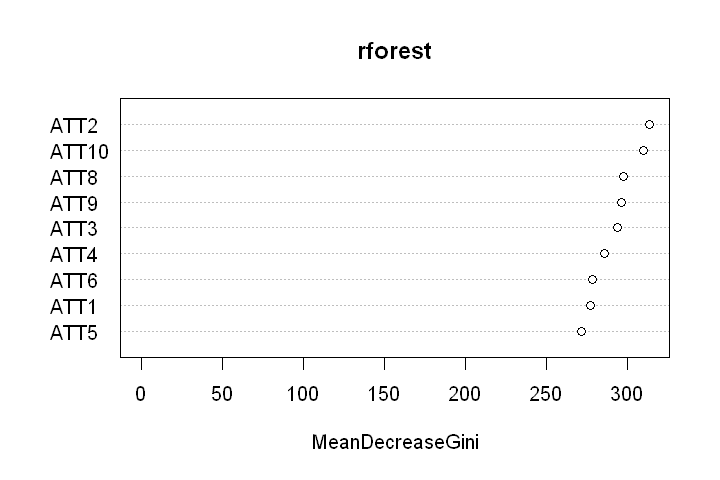

In [639]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
#varImpPlot(rforest)

## Cross Validation for Random Forest feature selection 

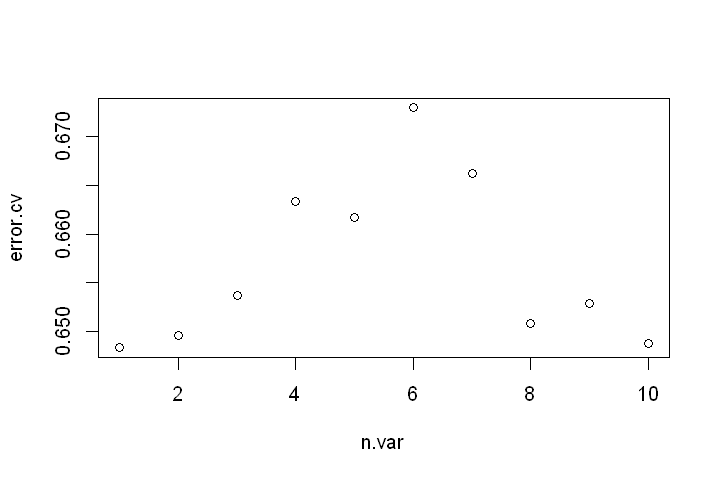

In [636]:
x <- train
x$Result <- NULL
y <- train$Result

rf.cv <- rfcv(x, y, cv.fold=10, step=0.9)

with(rf.cv, plot(n.var, error.cv))

Ok, this is telling us that an 8 feature model is performing the best. Let's try retrain the model without the lowest importance features and rerun the predictions

In [656]:
rforest <- randomForest(Result ~ . - ATT5 - ATT1, data = rforest_train)

In [657]:
rforest


Call:
 randomForest(formula = Result ~ . - ATT5 - ATT1, data = rforest_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 34.97%
Confusion matrix:
    0   1   2   3 class.error
0 392 352 116  20    0.554545
1 382 370 116  12    0.579545
2 106 115 648  11    0.263636
3   0   1   0 879    0.001136

In [658]:
print(importance(rforest,type = 2))

      MeanDecreaseGini
ATT2             331.4
ATT3             309.7
ATT4             309.0
ATT6             309.9
ATT7             320.2
ATT8             323.6
ATT9             321.5
ATT10            330.3


In [659]:
pred <- predict(rforest, test)

In [660]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0  88 110  55  16
         1  86  99  46  15
         2  24  26  19   6
         3   4   4   2   0

Overall Statistics
                                        
               Accuracy : 0.343         
                 95% CI : (0.305, 0.383)
    No Information Rate : 0.398         
    P-Value [Acc > NIR] : 0.998         
                                        
                  Kappa : 0.004         
 Mcnemar's Test P-Value : 0.00000249    

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.436    0.414   0.1557   0.0000
Specificity             0.545    0.593   0.8828   0.9822
Pos Pred Value          0.327    0.402   0.2533   0.0000
Neg Pred Value          0.656    0.605   0.8038   0.9373
Prevalence              0.337    0.398   0.2033   0.0617
Detection Rate          0.147    0.165   0.0317   0.0000
Detection Prevalence    0.448    0.410   0